<a href="https://colab.research.google.com/github/Jagriti301999/Intern_task/blob/main/Fb_Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

In [ ]:
company='FB' #canbe any company 
start=dt.datetime(2012,1,1)
end=dt.datetime(2021,1,1)

In [ ]:
data=web.DataReader(company,'yahoo',start,end)

In [ ]:
data.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [ ]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999
2020-12-30,278.079987,271.709991,277.950012,271.869995,11803800,271.869995
2020-12-31,277.089996,269.809998,272.000000,273.160004,12900400,273.160004


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2170 entries, 2012-05-18 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2170 non-null   float64
 1   Low        2170 non-null   float64
 2   Open       2170 non-null   float64
 3   Close      2170 non-null   float64
 4   Volume     2170 non-null   int64  
 5   Adj Close  2170 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 118.7 KB


In [ ]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2170.000000,2170.000000,2170.000000,2170.000000,2.170000e+03,2170.000000
mean,125.563945,122.630866,124.121313,124.157318,3.213096e+07,124.157318
std,68.878920,67.270939,68.074474,68.124602,2.858937e+07,68.124602
min,18.270000,17.549999,18.080000,17.730000,5.913100e+06,17.730000
25%,71.552502,69.612501,70.830000,70.849997,1.619055e+07,70.849997
50%,122.009998,119.750000,120.995003,120.820000,2.327860e+07,120.820000
75%,179.022495,175.779995,177.477501,177.470001,3.773498e+07,177.470001
max,304.670013,293.049988,300.160004,303.910004,5.735764e+08,303.910004


In [ ]:
#prepare data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days=60

In [ ]:
x_train=[]
y_train=[]

In [ ]:
for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

In [ ]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [ ]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of next closing

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

66/66 [==============================] - 6s 86ms/step - loss: 0.0016
Epoch 21/25
66/66 [==============================] - 6s 85ms/step - loss: 0.0015
Epoch 22/25
66/66 [==============================] - 6s 86ms/step - loss: 0.0014
Epoch 23/25
66/66 [==============================] - 6s 84ms/step - loss: 0.0013
Epoch 24/25
66/66 [==============================] - 6s 84ms/step - loss: 0.0012
Epoch 25/25
66/66 [==============================] - 6s 86ms/step - loss: 0.0013


In [ ]:
#=====Test The Model Accuracy on existing Data===

#load test Data
test_start=dt.datetime(2021,1,1)
test_end=dt.datetime.now()

test_data=web.DataReader(company,'yahoo',test_start,test_end)
actual_prices=test_data['Close'].values

total_dataset=pd.concat((data['Close'],test_data['Close']),axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs=scaler.transform(model_inputs)

In [ ]:
#Make Prediction On Test Data
x_test=[]
for x in range(prediction_days,len(model_inputs)+1):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)


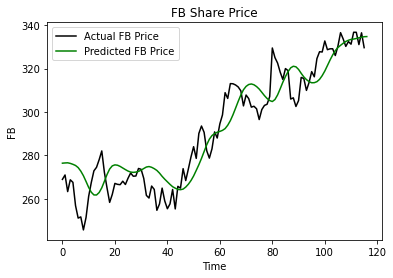

In [ ]:
#plot the test prediction
plt.plot(actual_prices,color='black',label=f'Actual {company} Price')
plt.plot(predicted_prices,color='green',label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company}')
plt.legend()
plt.show()


In [ ]:
#predict next day

real_data=[model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data=np.array(real_data)
real_data=np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction=model.predict(real_data)
prediction=scaler.inverse_transform(prediction)
#print('\n\n')
print(f'Tomorrow Prediction:{prediction}')

Tomorrow Prediction:[[334.7734]]


# New section